# Merge the prophage counts based on the host's taxonomy

We are going to use the [GTDB](https://gtdb.ecogenomic.org/) taxonomy to count the number of prophages at different levels. Because of this, we merge with the GTDB metadata file.

In [8]:
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import pandas as pd
import seaborn as sns
import numpy as np

import math
import re

from scipy.stats import pearsonr, f_oneway
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, tukeyhsd, MultiComparison

import subprocess
import gzip


In [3]:
# this is a neat trick for getting markdown in our output
# see https://stackoverflow.com/questions/23271575/printing-bold-colored-etc-text-in-ipython-qtconsole
# for the inspiration
from IPython.display import Markdown, display
def printmd(string, color="black"):
    colorstr = "<span style='color:{}'>{}</span>".format(color, string)
    display(Markdown(colorstr))

### Read the data file

The metadata is from GTDB. The phage data is from us.


In [6]:
taxadf = pd.read_csv("../small_data/bac120_metadata_r95.tsv.gz", compression='gzip', header=0, delimiter="\t")
taxadf

,accession,ambiguous_bases,checkm_completeness,checkm_contamination,checkm_marker_count,checkm_marker_lineage,checkm_marker_set_count,checkm_strain_heterogeneity,coding_bases,coding_density,...,ssu_silva_blast_align_len,ssu_silva_blast_bitscore,ssu_silva_blast_evalue,ssu_silva_blast_perc_identity,ssu_silva_blast_subject_id,ssu_silva_taxonomy,total_gap_length,trna_aa_count,trna_count,trna_selenocysteine_count
0,RS_GCF_000003135.1,0,100.00,0.00,476,f__Bifidobacteriaceae (UID1462),217,0.0,2074412,86.565160,...,1522,2811,0,100,AP014658.1453189.1454717,Bacteria;Actinobacteria;Actinobacteria;Bifidob...,23501,20,56,0
1,RS_GCF_000003645.1,20,99.07,0.02,1171,g__Bacillus (UID902),324,0.0,4406087,83.611327,...,572,1026,0,99.126,JRUS01000065.796.2379,Eukaryota;Opisthokonta;Nucletmycea;Fungi;Dikar...,24100,20,72,0
2,RS_GCF_000003925.1,30,99.32,0.02,1082,g__Bacillus (UID901),303,0.0,4540498,81.635648,...,1545,2854,0,100,CP000903.299789.301333,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,20000,20,83,0
3,RS_GCF_000003955.1,92,97.17,0.76,1082,g__Bacillus (UID901),303,0.0,4664382,80.552305,...,1457,2691,0,100,CP006863.2068708.2070251,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,41200,20,94,0
4,RS_GCF_000005825.2,0,98.68,1.32,273,c__Bacilli (UID257),151,0.0,3613115,85.029516,...,1549,2861,0,100,CP001878.164650.166210,Bacteria;Firmicutes;Bacilli;Bacillales;Bacilla...,0,20,77,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,RS_GCF_000009125.1,0,99.94,0.00,596,f__Burkholderiaceae (UID4003),218,0.0,5076746,87.365585,...,1532,2830,0,100,MOLK01000079.228.1772,Bacteria;Proteobacteria;Gammaproteobacteria;Be...,0,20,57,0
95,RS_GCF_000009145.1,0,99.97,0.74,414,c__Betaproteobacteria (UID3959),211,25.0,2494263,88.697711,...,1532,2830,0,100,AL954747.69146.70677,Bacteria;Proteobacteria;Gammaproteobacteria;Be...,0,20,41,0
96,RS_GCF_000009165.1,0,99.64,0.00,481,c__Gammaproteobacteria (UID4202),276,0.0,4661167,85.996979,...,1542,2848,0,100,FO681494.4835663.4837207,Bacteria;Proteobacteria;Gammaproteobacteria;Xa...,0,20,56,0
97,RS_GCF_000009245.1,0,99.82,0.41,675,o__Thiotrichales (UID4410),243,100.0,1678201,88.512991,...,1523,2813,0,100,CP003932.124404.125927,Bacteria;Proteobacteria;Gammaproteobacteria;Fr...,0,20,38,0


### Make sure we have the right column

PATRIC calls the column `assembly_accession` while GTDB calls it `ncbi_genbank_assembly_accession`

In [10]:
acccol = 'ncbi_genbank_assembly_accession'
taxadf[acccol]

0     GCA_000003135.1
1     GCA_000003645.1
2     GCA_000003925.1
3     GCA_000003955.1
4     GCA_000005825.2
           ...       
94    GCA_000009125.1
95    GCA_000009145.1
96    GCA_000009165.1
97    GCA_000009245.1
98    GCA_000009285.2
Name: ncbi_genbank_assembly_accession, Length: 99, dtype: object

### Abstract out the accession and name into new columns

This will allow us to merge the data with the PATRIC and GTDB data

In [12]:
def get_acc_name(x):
    regexp = re.compile('(\w+\.\d+)_([\w\.]+)_genomic.gbff.gz')
    m = regexp.match(x)
    if not m:
        sys.stderr.write(f"WARNING: Regexp did not match {x}\n")
        return (None, None)
    return list(m.groups())

phagesdf = pd.read_csv("../small_data/phages_per_genome.tsv.gz", compression='gzip', header=0, delimiter="\t")
phagesdf = pd.concat([pd.DataFrame.from_records(phagesdf['Contig'].apply(get_acc_name), columns=['Accession', 'Name']), phagesdf], axis=1)
phagesdf

,Accession,Name,Contig,Genome length,Contigs,Total Predicted Prophages,Kept,No phage genes,Not enough genes,bp prophage
0,GCA_000003135.1,ASM313v1,GCA_000003135.1_ASM313v1_genomic.gbff.gz,2396359,10,16,2,1,13,48916
1,GCA_000003645.1,ASM364v1,GCA_000003645.1_ASM364v1_genomic.gbff.gz,5269725,1,31,1,10,20,40297
2,GCA_000003925.1,ASM392v1,GCA_000003925.1_ASM392v1_genomic.gbff.gz,5561906,1,38,6,13,19,268081
3,GCA_000003955.1,ASM395v1,GCA_000003955.1_ASM395v1_genomic.gbff.gz,5790501,1,46,6,11,29,166286
4,GCA_000005825.2,ASM582v2,GCA_000005825.2_ASM582v2_genomic.gbff.gz,4249248,3,33,3,9,21,93416
...,...,...,...,...,...,...,...,...,...,...
94,GCA_000009125.1,ASM912v1,GCA_000009125.1_ASM912v1_genomic.gbff.gz,5810922,2,27,6,1,20,173228
95,GCA_000009145.1,ASM914v1,GCA_000009145.1_ASM914v1_genomic.gbff.gz,2812094,1,49,5,4,40,160952
96,GCA_000009165.1,ASM916v1,GCA_000009165.1_ASM916v1_genomic.gbff.gz,5420152,4,33,6,10,17,147339
97,GCA_000009245.1,ASM924v1,GCA_000009245.1_ASM924v1_genomic.gbff.gz,1895994,1,10,1,2,7,17948


### Do we need to combine to different levels

We can combined e.g. from Bacteria to Order. But do we need to?

In [40]:
toorder = len(pd.unique(taxadf.apply(lambda x: '_'.join(x[2:6].values.tolist()), axis=1)))
uniqueorder = len(pd.unique(taxadf['order']))
print(f"Unique orders: {uniqueorder} Unique to order: {toorder}")

Unique orders: 197 Unique to order: 345


In [63]:
taxadf['to_order'] = taxadf.apply(lambda x: '_'.join(x[2:6].values.tolist()), axis=1)
seen = {}
for o, too in zip(taxadf.order, taxadf.to_order):
    if 'o:' == o:
        continue
    if o in seen and seen[o] != too:
        print(f"For {o} had {seen[o]} but now {too}")
    seen[o] = too

In [65]:
taxadf[taxadf['order'] == 'o:']

,Genome,taxid,superkingdom,phylum,class,order,family,genus,species,prophages,to_order,to_phylum
116,phispy/GCA_00030/GCA_000307935/GCA_000307935.1...,1208365,s:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:,f:,g:,s:SAR86 cluster bacterium SAR86E,2,s:Bacteria_p:Proteobacteria_c:Gammaproteobacte...,s:Bacteria_p:Proteobacteria
269,phispy/GCA_00009/GCA_000091165/GCA_000091165.1...,671143,s:Bacteria,p:candidate division NC10,c:,o:,f:,g:Candidatus Methylomirabilis,s:Candidatus Methylomirabilis oxyfera,3,s:Bacteria_p:candidate division NC10_c:_o:,s:Bacteria_p:candidate division NC10
305,phispy/GCA_00009/GCA_000092645/GCA_000092645.1...,469371,s:Bacteria,p:Actinobacteria,c:Actinobacteria,o:,f:,g:Thermobispora,s:Thermobispora bispora,4,s:Bacteria_p:Actinobacteria_c:Actinobacteria_o:,s:Bacteria_p:Actinobacteria
379,phispy/GCA_00002/GCA_000024465/GCA_000024465.1...,488538,s:Bacteria,p:Proteobacteria,c:Alphaproteobacteria,o:,f:,g:Candidatus Puniceispirillum,s:Candidatus Puniceispirillum marinum,3,s:Bacteria_p:Proteobacteria_c:Alphaproteobacte...,s:Bacteria_p:Proteobacteria
380,phispy/GCA_00002/GCA_000024165/GCA_000024165.1...,522306,s:Bacteria,p:Proteobacteria,c:Betaproteobacteria,o:,f:,g:Candidatus Accumulibacter,s:Candidatus Accumulibacter phosphatis,7,s:Bacteria_p:Proteobacteria_c:Betaproteobacter...,s:Bacteria_p:Proteobacteria
...,...,...,...,...,...,...,...,...,...,...,...,...
75467,phispy/GCA_00999/GCA_009992695/GCA_009992695.1...,1913989,s:Bacteria,p:Proteobacteria,c:Gammaproteobacteria,o:,f:,g:,s:Gammaproteobacteria bacterium,0,s:Bacteria_p:Proteobacteria_c:Gammaproteobacte...,s:Bacteria_p:Proteobacteria
75468,phispy/GCA_00999/GCA_009992825/GCA_009992825.1...,2699743,s:Bacteria,p:Candidatus Kuenenbacteria,c:,o:,f:,g:,s:Candidatus Kuenenbacteria bacterium,0,s:Bacteria_p:Candidatus Kuenenbacteria_c:_o:,s:Bacteria_p:Candidatus Kuenenbacteria
75469,phispy/GCA_00999/GCA_009993695/GCA_009993695.1...,2699743,s:Bacteria,p:Candidatus Kuenenbacteria,c:,o:,f:,g:,s:Candidatus Kuenenbacteria bacterium,0,s:Bacteria_p:Candidatus Kuenenbacteria_c:_o:,s:Bacteria_p:Candidatus Kuenenbacteria
75479,phispy/GCA_00999/GCA_009992065/GCA_009992065.1...,2093373,s:Bacteria,p:Candidatus Microgenomates,c:,o:,f:,g:,s:Candidatus Microgenomates bacterium,0,s:Bacteria_p:Candidatus Microgenomates_c:_o:,s:Bacteria_p:Candidatus Microgenomates


### Combine the data.

This is the general approach to combine the data. Here we combine everything upto order. We are 0 indexed by column, so column 2 = superkingdom, column 5 = order.

Next, we aggregate by that new column.

In [5]:
taxadf['to_order'] = taxadf.apply(lambda x: '_'.join(x[2:6].values.tolist()), axis=1)
taxadf.groupby('to_order').aggregate({'prophages' : 'sum'})

,prophages
to_order,
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:,0
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:Acidobacteriales,58
s:Bacteria_p:Acidobacteria_c:Acidobacteriia_o:Bryobacterales,44
s:Bacteria_p:Acidobacteria_c:Blastocatellia_o:,8
s:Bacteria_p:Acidobacteria_c:Blastocatellia_o:Blastocatellales,0
...,...
s:Bacteria_p:candidate division LCP-89_c:_o:,2
s:Bacteria_p:candidate division NC10_c:_o:,14
s:Bacteria_p:candidate division WOR-3_c:_o:,5


### Aggregate using phylum and the mean

In fact, we want to aggregate the different phyla and then take the mean of the number of prophages per phyla.

In [6]:
taxadf['to_phylum'] = taxadf.apply(lambda x: '_'.join(x[2:4].values.tolist()), axis=1)
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp

,prophages
to_phylum,
s:Bacteria_p:Acidobacteria,1.059459
s:Bacteria_p:Actinobacteria,3.205085
s:Bacteria_p:Aquificae,0.500000
s:Bacteria_p:Armatimonadetes,0.968750
s:Bacteria_p:Bacteroidetes,3.441706
...,...
s:Bacteria_p:candidate division LCP-89,2.000000
s:Bacteria_p:candidate division NC10,2.333333
s:Bacteria_p:candidate division WOR-3,0.166667


Here, we replace the names in the index. Note that we only have bacteria, so we can drop that, and don't get me started on _Candidatus_. So we remove that too. After removing everything, we sort the table by this column and then  use it as the index. Finally, we remove the row that has no taxonomic information

In [7]:
# remove Bacteria and Candidatus and then sort the data
text_rename = lambda x: x.replace('s:Bacteria_p:', '').replace('Candidatus ', '')
tp = taxadf.groupby('to_phylum').aggregate({'prophages' : 'mean'})
tp = tp.reset_index()
tp['to_phylum'] = tp['to_phylum'].apply(text_rename)
tp = tp.sort_values('to_phylum').set_index('to_phylum')
tp = tp.iloc[1:]
tp

,prophages
to_phylum,
Abyssubacteria,1.000000
Acidobacteria,1.059459
Actinobacteria,3.205085
Aerophobetes,0.200000
Amesbacteria,0.333333
...,...
candidate division LCP-89,2.000000
candidate division NC10,2.333333
candidate division WOR-3,0.166667


### Make a plot

This makes a plot of the data, and sets the labels to be readable.

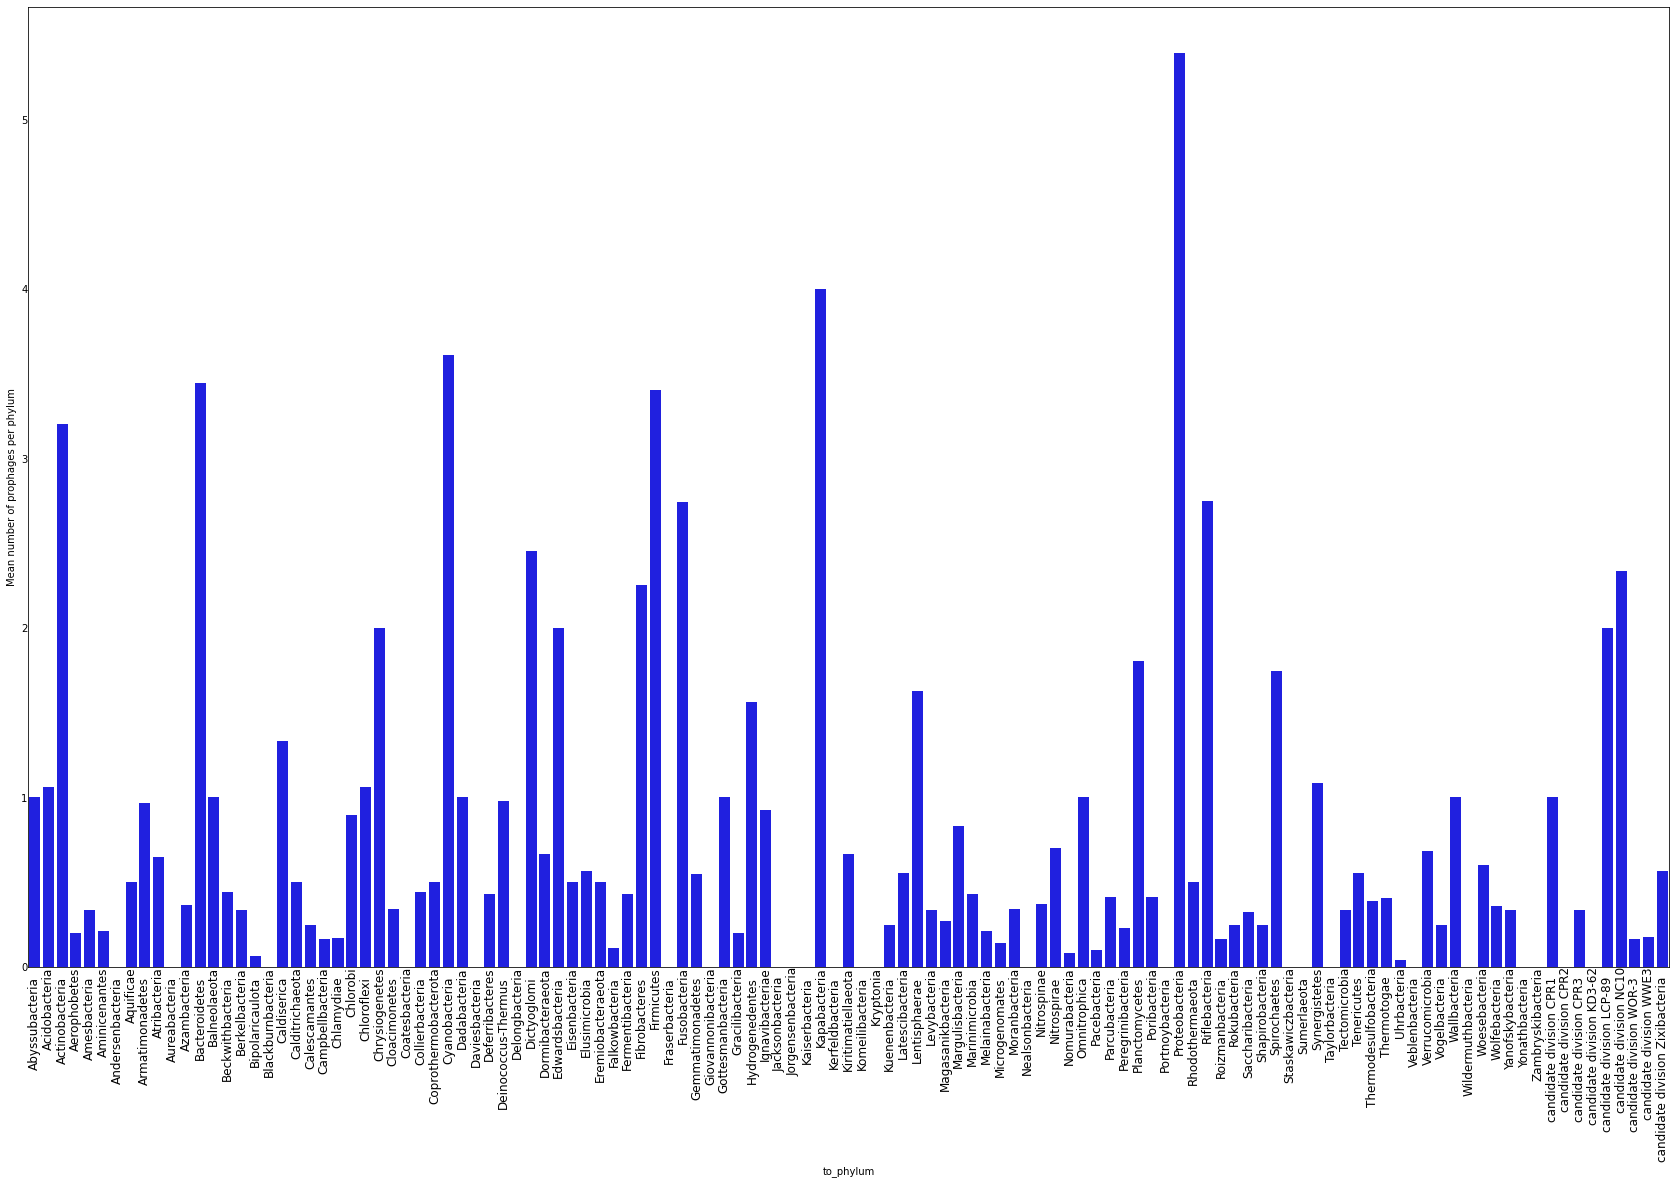

In [8]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.barplot(x=tp.index, y='prophages', data=tp, ax=ax, color='b')

# get the tick labels and change some parameters about them.
ticks_loc = ax.get_xticklabels()
l = ax.set_xticklabels(ticks_loc, rotation=90, horizontalalignment='center', fontsize=12)
# use this to hide every other tick
# [x.set_visible(False) for x in l[::2]]

# add a slight offset for every other tick label
for alab in l[::2]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# turn off the ticks themselves
ax.tick_params(length=0, pad=0)
ax.set_ylabel('Mean number of prophages per phylum')
plt.tight_layout()
fig.savefig('images/phyla.tiff')

In [9]:
taxadf[['to_phylum', 'prophages']]

,to_phylum,prophages
0,s:Bacteria_p:Spirochaetes,1
1,s:Bacteria_p:Proteobacteria,2
2,s:Bacteria_p:Proteobacteria,2
3,s:Bacteria_p:Proteobacteria,3
4,s:Bacteria_p:Proteobacteria,25
...,...,...
75478,s:Bacteria_p:Proteobacteria,8
75479,s:Bacteria_p:Candidatus Microgenomates,0
75480,s:Bacteria_p:Proteobacteria,0
75481,s:Bacteria_p:Candidatus Roizmanbacteria,0


# Statistical Analyses

Some stats on the number of prophages per taxonomic classification

# Effect Size Calculations

Our datasets are so large that even small effect sizes may have statistically significant differences. There is lots of discussion about this, for example see these posts and articles:

* [Effect size, confidence interval and statistical significance: a practical guide for biologists](https://people.kth.se/~lang/Effect_size.pdf)
* [It's the Effect Size, Stupid! What effect size is and why it is important](http://www.leeds.ac.uk/educol/documents/00002182.htm)
* [Large scale statistical analysis discussion on stats stackexchange](https://stats.stackexchange.com/questions/7815/what-skills-are-required-to-perform-large-scale-statistical-analyses)
* [Large data sets and hypothesis testing](https://stats.stackexchange.com/questions/2516/are-large-data-sets-inappropriate-for-hypothesis-testing)
* [The Dangers of Large Data Sets: A Tale of P values, Error Rates, and Bonferroni Corrections](https://thelogicofscience.com/2015/04/07/basic-statistics-part-3-the-dangers-of-large-data-sets-a-tale-of-p-values-error-rates-and-bonferroni-corrections/)
* [The Unofficial Google Data Blog](http://www.unofficialgoogledatascience.com/2016/10/practical-advice-for-analysis-of-large.html)

Because of these concerns, we include two measures of effect size.

## Cohen's f<sup>2</sup>

This is a measure of the effect size from the ANOVA:

f<sup>2</sup> = &#x003B7;<sup>2</sup>/(1 - &#x003B7;<sup>2</sup>)

This measures the combined effect size, and does not provide a pairwise comparison of the data.

According to Cohen (1988; pg. 413; Chapter 9) the effect sizes are: 

 * small effect size: f<sup>2</sup> = 0.02
 * medium effect size: f<sup>2</sup> = 0.15
 * large effect size: f<sup>2</sup> = 0.35

See chapter 9 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

# Cohen's d

This is a pairwise measure of the effect size, and can be used to compare our different groups or samples thereof.

According to Cohen (1988; pg. 26; Chapter 2) the effect sizes are:

 * small effect size: d = 0.2
 * medium effect size: d = 0.5
 * large effect size: d = 0.8
 
For a detailed exposition, see chapter 2 of [Cohen J. E. (1988). Statistical Power Analysis for the Behavioral Sciences. Hillsdale, NJ: Lawrence Erlbaum Associates, Inc](http://www.utstat.toronto.edu/~brunner/oldclass/378f16/readings/CohenPower.pdf)

In [10]:
def cohen_f(ssr,sse):
    """
    Calculate Cohen's f-squared from the Sum of Squares of Regression (SSR)
    and the Sum of Squares of Error (SSE).
    
    SSR is from the anova table as aov_table['sum_sq'][0]
    SSE is from the anova table as aov_table['sum_sq'][1]
    """
    
    rsq = ssr / (ssr + sse) # R^2 = SSR/SST
    return rsq / (1-rsq)

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)
    if np.isnan(d):
        # sys.stderr.write(f"{x} ~ {y} returned NaN\n")
        return 0
    return d

## Summary Statistics

This will be useful in our paper!

In [11]:
print("Phylum\tMinimum number of prophages\tMaximum number of prophages\tMean number of prophages\tMedian number of prophages\tStandard deviation")
for p in sorted(pd.unique(taxadf.to_phylum)):
    if len(text_rename(p)) == 0:
        continue
    d = taxadf[taxadf.to_phylum == p]
    count = d.prophages.count()
    m = d.prophages.min()
    x = d.prophages.max()
    n = round(d.prophages.mean(), 2)
    e = round(d.prophages.median(), 2)
    s = round(d.prophages.std(), 2)
    #print(f"Phylum: {text_rename(p)}, Min: {m}, Max: {x}, Mean: {n}, Median: {e}, stdev: {s}")
    #printmd(f"{text_rename(p)} (n: {count}, *M* = {n}, *SD* = {s})")
    print("\t".join(map(str, [text_rename(p), m, x, n, e, s])))

Phylum	Minimum number of prophages	Maximum number of prophages	Mean number of prophages	Median number of prophages	Standard deviation
Acidobacteria	0	11	1.06	0.0	1.8
Actinobacteria	0	74	3.21	2.0	3.74
Aquificae	0	2	0.5	0.0	0.78
Armatimonadetes	0	6	0.97	0.0	1.37
Bacteroidetes	0	29	3.44	2.0	4.62
Balneolaeota	0	6	1.0	0.0	1.75
Caldiserica	0	3	1.33	1.0	1.53
Calditrichaeota	0	2	0.5	0.0	0.76
Calescamantes	0	1	0.25	0.0	0.5
Absconditabacteria	0	2	0.67	0.0	1.15
Abyssubacteria	0	2	1.0	1.0	1.41
Aerophobetes	0	1	0.2	0.0	0.45
Amesbacteria	0	1	0.33	0.0	0.58
Aminicenantes	0	2	0.21	0.0	0.54
Andersenbacteria	0	0	0.0	0.0	nan
Atribacteria	0	2	0.65	1.0	0.59
Aureabacteria	0	0	0.0	0.0	nan
Azambacteria	0	4	0.36	0.0	1.21
Beckwithbacteria	0	2	0.44	0.0	0.73
Berkelbacteria	0	1	0.33	0.0	0.52
Bipolaricaulota	0	1	0.06	0.0	0.25
Blackburnbacteria	0	0	0.0	0.0	nan
Campbellbacteria	0	1	0.17	0.0	0.41
Cloacimonetes	0	5	0.34	0.0	0.91
Coatesbacteria	0	0	0.0	0.0	0.0
Collierbacteria	0	1	0.44	0.0	0.53
Dadabacteria	0	2	1.0	1.0	1.

# Anovas

I've used two different ways to calculate the ANOVA. The first is using _scipy.stats_ function _f\_oneway_ and the second is with statsmodels

### Calculate the one-way anova for all the data

Here, we group by _to_phylum_ and then compare the number of prophages in each group. Note that _group\_by_ returns a tuple of the grouped by name and the dataframe for that group, so _names_ is an array of the names and has the same dimension as _samples_. The 2D array _samples_ has one dimension for each name and the other for the number of prophages for that name.

In [12]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_phylum'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 76.296, p value: 0.000


### Repeat for order

Is there a significant difference in order

In [13]:
samples = []
names = []
for nm, groupdf in taxadf.groupby('to_order'):
    names.append(nm)
    samples.append(groupdf['prophages'])
f_val, p_val = f_oneway(*samples)
print('F value: {:.3f}, p value: {:.3f}'.format(f_val, p_val))

F value: 140.261, p value: 0.000


### Using statsmodels

Note that we have two measures of _phylum_: **phylum** is the actual phyla itself, while **to_phylum** is the concatenation of everything upto phylum.

For _phylum_ it doesn't matter, but for order it may (not sure if the orders are unique by themselves).


In [14]:
mod = ols('prophages ~ phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['phylum'], 2),
    round(aov_table.get("PR(>F)")['phylum'], 4)
))

                sum_sq       df          F  PR(>F)
phylum    1.252735e+05    119.0  76.295686     0.0
Residual  1.034827e+06  74999.0        NaN     NaN



<span style='color:black'>Report as: *F*(119, 74999) = 76.3, *p* = 0.0</span>

In [15]:
mod = ols('prophages ~ to_phylum', data=taxadf).fit()
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)
print()
printmd("Report as: *F*({}, {}) = {}, *p* = {}".format(
    int(aov_table.df['to_phylum']), 
    int(aov_table.df['Residual']),
    round(aov_table.F['to_phylum'], 2),
    round(aov_table.get("PR(>F)")['to_phylum'], 4)
))

                 sum_sq       df          F  PR(>F)
to_phylum  1.252735e+05    119.0  76.295686     0.0
Residual   1.034827e+06  74999.0        NaN     NaN



<span style='color:black'>Report as: *F*(119, 74999) = 76.3, *p* = 0.0</span>

### Use Tukey's honestly significant difference test to compare the data

This performs pairwise comparisons on our data. The NULL hypothesis is that there is no statistical difference in the means of the two samples. If we reject that NULL hypothesis (reject == True) then we have reason to believe that there is a significan difference in the means of the samples.

In [16]:
rec = pairwise_tukeyhsd(taxadf['prophages'], taxadf['phylum'])
print(rec)

                           Multiple Comparison of Means - Tukey HSD, FWER=0.05                           
             group1                           group2              meandiff p-adj   lower    upper  reject
---------------------------------------------------------------------------------------------------------
                p:Acidobacteria                  p:Actinobacteria   2.1456  0.001   0.9281  3.3631   True
                p:Acidobacteria                       p:Aquificae  -0.5595    0.9  -3.7635  2.6445  False
                p:Acidobacteria                 p:Armatimonadetes  -0.0907    0.9  -2.4514    2.27  False
                p:Acidobacteria                   p:Bacteroidetes   2.3822  0.001   1.1491  3.6154   True
                p:Acidobacteria                    p:Balneolaeota  -0.0595    0.9  -3.8912  3.7723  False
                p:Acidobacteria                     p:Caldiserica   0.2739    0.9  -9.2006  9.7483  False
                p:Acidobacteria               

In [17]:
tukeysres = pd.DataFrame(data=rec._results_table.data[1:], columns=rec._results_table.data[0])
tukeysres[tukeysres['reject'] == True]

,group1,group2,meandiff,p-adj,lower,upper,reject
0,p:Acidobacteria,p:Actinobacteria,2.1456,0.0010,0.9281,3.3631,True
3,p:Acidobacteria,p:Bacteroidetes,2.3822,0.0010,1.1491,3.6154,True
87,p:Acidobacteria,p:Cyanobacteria,2.5508,0.0010,1.0976,4.0040,True
93,p:Acidobacteria,p:Firmicutes,2.3459,0.0010,1.1422,3.5495,True
102,p:Acidobacteria,p:Proteobacteria,4.3333,0.0010,3.1341,5.5326,True
...,...,...,...,...,...,...,...
7010,p:Proteobacteria,p:Verrucomicrobia,-4.7070,0.0010,-5.6562,-3.7577,True
7017,p:Proteobacteria,p:candidate division WOR-3,-5.2261,0.0010,-8.1992,-2.2531,True
7018,p:Proteobacteria,p:candidate division WWE3,-5.2163,0.0010,-9.1652,-1.2674,True
7019,p:Proteobacteria,p:candidate division Zixibacteria,-4.8276,0.0010,-8.2228,-1.4324,True


## Effect size

We measure the effect size of the group as a whole from the anova using Cohen's f<sup>2</sup> and pairwise using Cohen's d.

In [18]:
phyla = pd.unique(taxadf['phylum'])
for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            continue
        print("Cohen's d for {} - {}: {}".format(c, d, round(
            cohen_d(
                taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'], 
        ), 2)))

Cohen's d for p:Spirochaetes - p:Proteobacteria: -0.89
Cohen's d for p:Spirochaetes - p:Firmicutes: -0.7
Cohen's d for p:Spirochaetes - p:Actinobacteria: -0.41
Cohen's d for p:Spirochaetes - p:Thermotogae: 0.77
Cohen's d for p:Spirochaetes - p:Cyanobacteria: -0.57
Cohen's d for p:Spirochaetes - p:Bacteroidetes: -0.4
Cohen's d for p:Spirochaetes - p:Deinococcus-Thermus: 0.42
Cohen's d for p:Spirochaetes - p:Planctomycetes: -0.03
Cohen's d for p:Spirochaetes - p:Chlamydiae: 0.97
Cohen's d for p:Spirochaetes - p:Tenericutes: 0.7
Cohen's d for p:Spirochaetes - p:Chlorobi: 0.47
Cohen's d for p:Spirochaetes - p:Aquificae: 0.69
Cohen's d for p:Spirochaetes - p:Chloroflexi: 0.29
Cohen's d for p:Spirochaetes - p:candidate division NC10: -0.32
Cohen's d for p:Spirochaetes - p:Coprothermobacterota: 0.68
Cohen's d for p:Spirochaetes - p:Dictyoglomi: -0.39
Cohen's d for p:Spirochaetes - p:Fibrobacteres: -0.27
Cohen's d for p:Spirochaetes - p:Synergistetes: 0.37
Cohen's d for p:Spirochaetes - p:Defe

Cohen's d for p:Proteobacteria - p:Verrucomicrobia: 1.14
Cohen's d for p:Proteobacteria - p:Elusimicrobia: 1.17
Cohen's d for p:Proteobacteria - p:Acidobacteria: 1.05
Cohen's d for p:Proteobacteria - p:Candidatus Saccharibacteria: 1.23
Cohen's d for p:Proteobacteria - p:Candidatus Melainabacteria: 1.25
Cohen's d for p:Proteobacteria - p:Calditrichaeota: 1.18
Cohen's d for p:Proteobacteria - p:Nitrospinae: 1.22
Cohen's d for p:Proteobacteria - p:Gemmatimonadetes: 1.17
Cohen's d for p:Proteobacteria - p:Balneolaeota: 1.06
Cohen's d for p:Proteobacteria - p:Candidatus Marinimicrobia: 1.2
Cohen's d for p:Proteobacteria - p:Candidatus Poribacteria: 1.21
Cohen's d for p:Proteobacteria - p:Rhodothermaeota: 1.18
Cohen's d for p:Proteobacteria - p:Candidatus Woesebacteria: 1.16
Cohen's d for p:Proteobacteria - p:candidate division WOR-3: 1.26
Cohen's d for p:Proteobacteria - p:Lentisphaerae: 0.91
Cohen's d for p:Proteobacteria - p:Candidatus Latescibacteria: 1.17
Cohen's d for p:Proteobacteria 

Cohen's d for p:Firmicutes - p:Candidatus Cloacimonetes: 1.28
Cohen's d for p:Firmicutes - p:Candidatus Veblenbacteria: 1.42
Cohen's d for p:Firmicutes - p:Candidatus Edwardsbacteria: 0
Cohen's d for p:Firmicutes - p:Candidatus Zambryskibacteria: 1.42
Cohen's d for p:Firmicutes - p:candidate division Zixibacteria: 1.19
Cohen's d for p:Firmicutes - p:Candidatus Peregrinibacteria: 1.33
Cohen's d for p:Firmicutes - p:Candidatus Uhrbacteria: 1.41
Cohen's d for p:Firmicutes - p:Candidatus Omnitrophica: 1.01
Cohen's d for p:Firmicutes - p:Candidatus Aminicenantes: 1.34
Cohen's d for p:Firmicutes - p:Candidatus Pacebacteria: 1.38
Cohen's d for p:Firmicutes - p:candidate division WWE3: 1.35
Cohen's d for p:Firmicutes - p:Candidatus Beckwithbacteria: 1.24
Cohen's d for p:Firmicutes - p:Thermodesulfobacteria: 1.26
Cohen's d for p:Firmicutes - p:candidate division CPR2: 1.42
Cohen's d for p:Firmicutes - p:Candidatus Atribacteria: 1.15
Cohen's d for p:Firmicutes - p:Candidatus Komeilibacteria: 1.4

Cohen's d for p:Actinobacteria - p:Candidatus Kapabacteria: 0
Cohen's d for p:Actinobacteria - p:Candidatus Aerophobetes: 0.8
Cohen's d for p:Actinobacteria - p:candidate division LCP-89: 0
Cohen's d for p:Actinobacteria - p:Armatimonadetes: 0.6
Cohen's d for p:Actinobacteria - p:Candidatus Kryptonia: 0.86
Cohen's d for p:Actinobacteria - p:Candidatus Kaiserbacteria: 0.86
Cohen's d for p:Actinobacteria - p:Candidatus Moranbacteria: 0.77
Cohen's d for p:Actinobacteria - p:Ignavibacteriae: 0.61
Cohen's d for p:Actinobacteria - p:Candidatus Hydrogenedentes: 0.44
Cohen's d for p:Actinobacteria - p:Candidatus Parcubacteria: 0.75
Cohen's d for p:Actinobacteria - p:Candidatus Fermentibacteria: 0.74
Cohen's d for p:Actinobacteria - p:Candidatus Absconditabacteria: 0.68
Cohen's d for p:Actinobacteria - p:Candidatus Gracilibacteria: 0.8
Cohen's d for p:Actinobacteria - p:Candidatus Campbellbacteria: 0.81
Cohen's d for p:Actinobacteria - p:Candidatus Delongbacteria: 0.86
Cohen's d for p:Actinobac

Cohen's d for p:Thermotogae - p:Candidatus Azambacteria: 0.06
Cohen's d for p:Thermotogae - p:Candidatus Amesbacteria: 0.12
Cohen's d for p:Thermotogae - p:Candidatus Levybacteria: 0.12
Cohen's d for p:Thermotogae - p:Candidatus Vogelbacteria: 0.26
Cohen's d for p:Thermotogae - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Thermotogae - p:Candidatus Sumerlaeota: 0.68
Cohen's d for p:Thermotogae - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Thermotogae - p:Candidatus Shapirobacteria: 0.26
Cohen's d for p:Thermotogae - p:Candidatus Berkelbacteria: 0.12
Cohen's d for p:Thermotogae - p:Candidatus Rokubacteria: 0.25
Cohen's d for p:Thermotogae - p:Candidatus Taylorbacteria: 0.67
Cohen's d for p:Thermotogae - p:Kiritimatiellaeota: -0.4
Cohen's d for p:Thermotogae - p:Candidatus Margulisbacteria: -0.71
Cohen's d for p:Thermotogae - p:Candidatus Portnoybacteria: 0.67
Cohen's d for p:Thermotogae - p:candidate division CPR1: 0
Cohen's d for p:Thermotogae - p:Candidatus Riflebacteria: -2

Cohen's d for p:Cyanobacteria - p:Candidatus Dadabacteria: 0.54
Cohen's d for p:Cyanobacteria - p:Candidatus Wildermuthbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:candidate division CPR3: 0.68
Cohen's d for p:Cyanobacteria - p:Candidatus Staskawiczbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:Candidatus Nealsonbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:Candidatus Jorgensenbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:Candidatus Fraserbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:Candidatus Coatesbacteria: 0.75
Cohen's d for p:Cyanobacteria - p:Candidatus Roizmanbacteria: 0.72
Cohen's d for p:Cyanobacteria - p:Candidatus Tectomicrobia: 0.68
Cohen's d for p:Cyanobacteria - p:Candidatus Dormibacteraeota: 0.61
Cohen's d for p:Cyanobacteria - p:Candidatus Eremiobacteraeota: 0.64
Cohen's d for p:Cyanobacteria - p:Calescamantes: 0.7
Cohen's d for p:Cyanobacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Cyanobacteria - p:Candidatus Eisenbacteria: 0.64
Cohen's d 

Cohen's d for p:Deinococcus-Thermus - p:Chlorobi: 0.05
Cohen's d for p:Deinococcus-Thermus - p:Aquificae: 0.32
Cohen's d for p:Deinococcus-Thermus - p:Chloroflexi: -0.03
Cohen's d for p:Deinococcus-Thermus - p:candidate division NC10: -0.76
Cohen's d for p:Deinococcus-Thermus - p:Coprothermobacterota: 0.29
Cohen's d for p:Deinococcus-Thermus - p:Dictyoglomi: -0.91
Cohen's d for p:Deinococcus-Thermus - p:Fibrobacteres: -0.72
Cohen's d for p:Deinococcus-Thermus - p:Synergistetes: -0.08
Cohen's d for p:Deinococcus-Thermus - p:Deferribacteres: 0.34
Cohen's d for p:Deinococcus-Thermus - p:Nitrospirae: 0.19
Cohen's d for p:Deinococcus-Thermus - p:Fusobacteria: -0.94
Cohen's d for p:Deinococcus-Thermus - p:Verrucomicrobia: 0.23
Cohen's d for p:Deinococcus-Thermus - p:Elusimicrobia: 0.27
Cohen's d for p:Deinococcus-Thermus - p:Acidobacteria: -0.05
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Saccharibacteria: 0.44
Cohen's d for p:Deinococcus-Thermus - p:Candidatus Melainabacteria: 0.51
C

Cohen's d for p:Planctomycetes - p:Nitrospinae: 0.6
Cohen's d for p:Planctomycetes - p:Gemmatimonadetes: 0.55
Cohen's d for p:Planctomycetes - p:Balneolaeota: 0.33
Cohen's d for p:Planctomycetes - p:Candidatus Marinimicrobia: 0.64
Cohen's d for p:Planctomycetes - p:Candidatus Poribacteria: 0.58
Cohen's d for p:Planctomycetes - p:Rhodothermaeota: 0.53
Cohen's d for p:Planctomycetes - p:Candidatus Woesebacteria: 0.51
Cohen's d for p:Planctomycetes - p:candidate division WOR-3: 0.7
Cohen's d for p:Planctomycetes - p:Lentisphaerae: 0.07
Cohen's d for p:Planctomycetes - p:Candidatus Latescibacteria: 0.52
Cohen's d for p:Planctomycetes - p:Candidatus Cloacimonetes: 0.62
Cohen's d for p:Planctomycetes - p:Candidatus Veblenbacteria: 0.74
Cohen's d for p:Planctomycetes - p:Candidatus Edwardsbacteria: 0
Cohen's d for p:Planctomycetes - p:Candidatus Zambryskibacteria: 0.74
Cohen's d for p:Planctomycetes - p:candidate division Zixibacteria: 0.52
Cohen's d for p:Planctomycetes - p:Candidatus Peregr

Cohen's d for p:Chlamydiae - p:Candidatus Kapabacteria: 0
Cohen's d for p:Chlamydiae - p:Candidatus Aerophobetes: -0.04
Cohen's d for p:Chlamydiae - p:candidate division LCP-89: 0
Cohen's d for p:Chlamydiae - p:Armatimonadetes: -0.91
Cohen's d for p:Chlamydiae - p:Candidatus Kryptonia: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Kaiserbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Moranbacteria: -0.26
Cohen's d for p:Chlamydiae - p:Ignavibacteriae: -0.99
Cohen's d for p:Chlamydiae - p:Candidatus Hydrogenedentes: -1.67
Cohen's d for p:Chlamydiae - p:Candidatus Parcubacteria: -0.35
Cohen's d for p:Chlamydiae - p:Candidatus Fermentibacteria: -0.38
Cohen's d for p:Chlamydiae - p:Candidatus Absconditabacteria: -0.72
Cohen's d for p:Chlamydiae - p:Candidatus Gracilibacteria: -0.04
Cohen's d for p:Chlamydiae - p:Candidatus Campbellbacteria: 0.01
Cohen's d for p:Chlamydiae - p:Candidatus Delongbacteria: 0.25
Cohen's d for p:Chlamydiae - p:Candidatus Wallbacteria: 0
Cohen's d for p

Cohen's d for p:Tenericutes - p:Candidatus Vogelbacteria: 0.26
Cohen's d for p:Tenericutes - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Tenericutes - p:Candidatus Sumerlaeota: 0.47
Cohen's d for p:Tenericutes - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Tenericutes - p:Candidatus Shapirobacteria: 0.26
Cohen's d for p:Tenericutes - p:Candidatus Berkelbacteria: 0.19
Cohen's d for p:Tenericutes - p:Candidatus Rokubacteria: 0.27
Cohen's d for p:Tenericutes - p:Candidatus Taylorbacteria: 0.47
Cohen's d for p:Tenericutes - p:Kiritimatiellaeota: -0.09
Cohen's d for p:Tenericutes - p:Candidatus Margulisbacteria: -0.24
Cohen's d for p:Tenericutes - p:Candidatus Portnoybacteria: 0.47
Cohen's d for p:Tenericutes - p:candidate division CPR1: 0
Cohen's d for p:Tenericutes - p:Candidatus Riflebacteria: -1.78
Cohen's d for p:Tenericutes - p:Caldiserica: -0.66
Cohen's d for p:Tenericutes - p:Chrysiogenetes: 0
Cohen's d for p:Tenericutes - p:Candidatus Dadabacteria: -0.38
Cohen's d for p:T

Cohen's d for p:Chlorobi - p:Candidatus Abyssubacteria: -0.09
Cohen's d for p:Chlorobi - p:Candidatus Aureabacteria: 0
Cohen's d for p:Chlorobi - p:candidate division KD3-62: 0
Cohen's d for p:Aquificae - p:Chloroflexi: -0.21
Cohen's d for p:Aquificae - p:candidate division NC10: -1.35
Cohen's d for p:Aquificae - p:Coprothermobacterota: 0.0
Cohen's d for p:Aquificae - p:Dictyoglomi: -2.3
Cohen's d for p:Aquificae - p:Fibrobacteres: -1.16
Cohen's d for p:Aquificae - p:Synergistetes: -0.62
Cohen's d for p:Aquificae - p:Deferribacteres: 0.09
Cohen's d for p:Aquificae - p:Nitrospirae: -0.17
Cohen's d for p:Aquificae - p:Fusobacteria: -1.21
Cohen's d for p:Aquificae - p:Verrucomicrobia: -0.17
Cohen's d for p:Aquificae - p:Elusimicrobia: -0.07
Cohen's d for p:Aquificae - p:Acidobacteria: -0.33
Cohen's d for p:Aquificae - p:Candidatus Saccharibacteria: 0.25
Cohen's d for p:Aquificae - p:Candidatus Melainabacteria: 0.43
Cohen's d for p:Aquificae - p:Calditrichaeota: 0.0
Cohen's d for p:Aquific

Cohen's d for p:Chloroflexi - p:Candidatus Pacebacteria: 0.36
Cohen's d for p:Chloroflexi - p:candidate division WWE3: 0.33
Cohen's d for p:Chloroflexi - p:Candidatus Beckwithbacteria: 0.23
Cohen's d for p:Chloroflexi - p:Thermodesulfobacteria: 0.25
Cohen's d for p:Chloroflexi - p:candidate division CPR2: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Atribacteria: 0.15
Cohen's d for p:Chloroflexi - p:Candidatus Komeilibacteria: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Kerfeldbacteria: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Daviesbacteria: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Kapabacteria: 0
Cohen's d for p:Chloroflexi - p:Candidatus Aerophobetes: 0.32
Cohen's d for p:Chloroflexi - p:candidate division LCP-89: 0
Cohen's d for p:Chloroflexi - p:Armatimonadetes: 0.04
Cohen's d for p:Chloroflexi - p:Candidatus Kryptonia: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Kaiserbacteria: 0.39
Cohen's d for p:Chloroflexi - p:Candidatus Moranbacteria: 0.27
Cohen's d 

Cohen's d for p:candidate division NC10 - p:Candidatus Wallbacteria: 0
Cohen's d for p:candidate division NC10 - p:Candidatus Magasanikbacteria: 1.16
Cohen's d for p:candidate division NC10 - p:Candidatus Yanofskybacteria: 0.78
Cohen's d for p:candidate division NC10 - p:Candidatus Wolfebacteria: 1.18
Cohen's d for p:candidate division NC10 - p:Candidatus Collierbacteria: 0.99
Cohen's d for p:candidate division NC10 - p:Candidatus Yonathbacteria: 0.98
Cohen's d for p:candidate division NC10 - p:Candidatus Nomurabacteria: 1.77
Cohen's d for p:candidate division NC10 - p:Candidatus Bipolaricaulota: 1.49
Cohen's d for p:candidate division NC10 - p:Candidatus Jacksonbacteria: 1.15
Cohen's d for p:candidate division NC10 - p:Candidatus Falkowbacteria: 1.18
Cohen's d for p:candidate division NC10 - p:Candidatus Azambacteria: 0.99
Cohen's d for p:candidate division NC10 - p:Candidatus Amesbacteria: 0.78
Cohen's d for p:candidate division NC10 - p:Candidatus Levybacteria: 0.78
Cohen's d for p:

Cohen's d for p:Coprothermobacterota - p:Candidatus Levybacteria: 0.27
Cohen's d for p:Coprothermobacterota - p:Candidatus Vogelbacteria: 0.45
Cohen's d for p:Coprothermobacterota - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Coprothermobacterota - p:Candidatus Sumerlaeota: 1.58
Cohen's d for p:Coprothermobacterota - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Coprothermobacterota - p:Candidatus Shapirobacteria: 0.45
Cohen's d for p:Coprothermobacterota - p:Candidatus Berkelbacteria: 0.3
Cohen's d for p:Coprothermobacterota - p:Candidatus Rokubacteria: 0.36
Cohen's d for p:Coprothermobacterota - p:Candidatus Taylorbacteria: 1.41
Cohen's d for p:Coprothermobacterota - p:Kiritimatiellaeota: -0.17
Cohen's d for p:Coprothermobacterota - p:Candidatus Margulisbacteria: -0.71
Cohen's d for p:Coprothermobacterota - p:Candidatus Portnoybacteria: 1.0
Cohen's d for p:Coprothermobacterota - p:candidate division CPR1: 0
Cohen's d for p:Coprothermobacterota - p:Candidatus Riflebacteria: -

Cohen's d for p:Dictyoglomi - p:Candidatus Kuenenbacteria: 2.35
Cohen's d for p:Dictyoglomi - p:Candidatus Microgenomates: 2.72
Cohen's d for p:Dictyoglomi - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Dictyoglomi - p:Candidatus Abyssubacteria: 1.35
Cohen's d for p:Dictyoglomi - p:Candidatus Aureabacteria: 0
Cohen's d for p:Dictyoglomi - p:candidate division KD3-62: 0
Cohen's d for p:Fibrobacteres - p:Synergistetes: 0.82
Cohen's d for p:Fibrobacteres - p:Deferribacteres: 0.98
Cohen's d for p:Fibrobacteres - p:Nitrospirae: 1.06
Cohen's d for p:Fibrobacteres - p:Fusobacteria: -0.24
Cohen's d for p:Fibrobacteres - p:Verrucomicrobia: 1.29
Cohen's d for p:Fibrobacteres - p:Elusimicrobia: 1.12
Cohen's d for p:Fibrobacteres - p:Acidobacteria: 0.65
Cohen's d for p:Fibrobacteres - p:Candidatus Saccharibacteria: 1.3
Cohen's d for p:Fibrobacteres - p:Candidatus Melainabacteria: 1.39
Cohen's d for p:Fibrobacteres - p:Calditrichaeota: 0.96
Cohen's d for p:Fibrobacteres - p:Nitrospinae: 1.16
C

Cohen's d for p:Synergistetes - p:candidate division WWE3: 0.99
Cohen's d for p:Synergistetes - p:Candidatus Beckwithbacteria: 0.65
Cohen's d for p:Synergistetes - p:Thermodesulfobacteria: 0.7
Cohen's d for p:Synergistetes - p:candidate division CPR2: 1.07
Cohen's d for p:Synergistetes - p:Candidatus Atribacteria: 0.47
Cohen's d for p:Synergistetes - p:Candidatus Komeilibacteria: 1.09
Cohen's d for p:Synergistetes - p:Candidatus Kerfeldbacteria: 1.08
Cohen's d for p:Synergistetes - p:Candidatus Daviesbacteria: 1.08
Cohen's d for p:Synergistetes - p:Candidatus Kapabacteria: 0
Cohen's d for p:Synergistetes - p:Candidatus Aerophobetes: 0.89
Cohen's d for p:Synergistetes - p:candidate division LCP-89: 0
Cohen's d for p:Synergistetes - p:Armatimonadetes: 0.1
Cohen's d for p:Synergistetes - p:Candidatus Kryptonia: 1.11
Cohen's d for p:Synergistetes - p:Candidatus Kaiserbacteria: 1.11
Cohen's d for p:Synergistetes - p:Candidatus Moranbacteria: 0.84
Cohen's d for p:Synergistetes - p:Ignavibact

Cohen's d for p:Deferribacteres - p:Candidatus Azambacteria: 0.06
Cohen's d for p:Deferribacteres - p:Candidatus Amesbacteria: 0.13
Cohen's d for p:Deferribacteres - p:Candidatus Levybacteria: 0.13
Cohen's d for p:Deferribacteres - p:Candidatus Vogelbacteria: 0.25
Cohen's d for p:Deferribacteres - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Deferribacteres - p:Candidatus Sumerlaeota: 0.7
Cohen's d for p:Deferribacteres - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Deferribacteres - p:Candidatus Shapirobacteria: 0.25
Cohen's d for p:Deferribacteres - p:Candidatus Berkelbacteria: 0.14
Cohen's d for p:Deferribacteres - p:Candidatus Rokubacteria: 0.25
Cohen's d for p:Deferribacteres - p:Candidatus Taylorbacteria: 0.67
Cohen's d for p:Deferribacteres - p:Kiritimatiellaeota: -0.26
Cohen's d for p:Deferribacteres - p:Candidatus Margulisbacteria: -0.63
Cohen's d for p:Deferribacteres - p:Candidatus Portnoybacteria: 0.59
Cohen's d for p:Deferribacteres - p:candidate division CPR1: 0


Cohen's d for p:Nitrospirae - p:Candidatus Abyssubacteria: -0.23
Cohen's d for p:Nitrospirae - p:Candidatus Aureabacteria: 0
Cohen's d for p:Nitrospirae - p:candidate division KD3-62: 0
Cohen's d for p:Fusobacteria - p:Verrucomicrobia: 1.44
Cohen's d for p:Fusobacteria - p:Elusimicrobia: 1.2
Cohen's d for p:Fusobacteria - p:Acidobacteria: 0.89
Cohen's d for p:Fusobacteria - p:Candidatus Saccharibacteria: 1.31
Cohen's d for p:Fusobacteria - p:Candidatus Melainabacteria: 1.37
Cohen's d for p:Fusobacteria - p:Calditrichaeota: 1.13
Cohen's d for p:Fusobacteria - p:Nitrospinae: 1.25
Cohen's d for p:Fusobacteria - p:Gemmatimonadetes: 1.25
Cohen's d for p:Fusobacteria - p:Balneolaeota: 0.87
Cohen's d for p:Fusobacteria - p:Candidatus Marinimicrobia: 1.52
Cohen's d for p:Fusobacteria - p:Candidatus Poribacteria: 1.21
Cohen's d for p:Fusobacteria - p:Rhodothermaeota: 1.11
Cohen's d for p:Fusobacteria - p:Candidatus Woesebacteria: 1.13
Cohen's d for p:Fusobacteria - p:candidate division WOR-3: 1

Cohen's d for p:Verrucomicrobia - p:candidate division LCP-89: 0
Cohen's d for p:Verrucomicrobia - p:Armatimonadetes: -0.24
Cohen's d for p:Verrucomicrobia - p:Candidatus Kryptonia: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Kaiserbacteria: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Moranbacteria: 0.32
Cohen's d for p:Verrucomicrobia - p:Ignavibacteriae: -0.22
Cohen's d for p:Verrucomicrobia - p:Candidatus Hydrogenedentes: -0.75
Cohen's d for p:Verrucomicrobia - p:Candidatus Parcubacteria: 0.26
Cohen's d for p:Verrucomicrobia - p:Candidatus Fermentibacteria: 0.23
Cohen's d for p:Verrucomicrobia - p:Candidatus Absconditabacteria: 0.02
Cohen's d for p:Verrucomicrobia - p:Candidatus Gracilibacteria: 0.44
Cohen's d for p:Verrucomicrobia - p:Candidatus Campbellbacteria: 0.47
Cohen's d for p:Verrucomicrobia - p:Candidatus Delongbacteria: 0.62
Cohen's d for p:Verrucomicrobia - p:Candidatus Wallbacteria: 0
Cohen's d for p:Verrucomicrobia - p:Candidatus Magasanikbacteria: 0.38

Cohen's d for p:Elusimicrobia - p:Candidatus Berkelbacteria: 0.22
Cohen's d for p:Elusimicrobia - p:Candidatus Rokubacteria: 0.33
Cohen's d for p:Elusimicrobia - p:Candidatus Taylorbacteria: 0.54
Cohen's d for p:Elusimicrobia - p:Kiritimatiellaeota: -0.09
Cohen's d for p:Elusimicrobia - p:Candidatus Margulisbacteria: -0.26
Cohen's d for p:Elusimicrobia - p:Candidatus Portnoybacteria: 0.53
Cohen's d for p:Elusimicrobia - p:candidate division CPR1: 0
Cohen's d for p:Elusimicrobia - p:Candidatus Riflebacteria: -1.61
Cohen's d for p:Elusimicrobia - p:Caldiserica: -0.69
Cohen's d for p:Elusimicrobia - p:Chrysiogenetes: 0
Cohen's d for p:Elusimicrobia - p:Candidatus Dadabacteria: -0.4
Cohen's d for p:Elusimicrobia - p:Candidatus Wildermuthbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:candidate division CPR3: 0.22
Cohen's d for p:Elusimicrobia - p:Candidatus Staskawiczbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candidatus Nealsonbacteria: 0.53
Cohen's d for p:Elusimicrobia - p:Candida

Cohen's d for p:Candidatus Saccharibacteria - p:Gemmatimonadetes: -0.21
Cohen's d for p:Candidatus Saccharibacteria - p:Balneolaeota: -0.56
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Marinimicrobia: -0.18
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Poribacteria: -0.14
Cohen's d for p:Candidatus Saccharibacteria - p:Rhodothermaeota: -0.29
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Woesebacteria: -0.46
Cohen's d for p:Candidatus Saccharibacteria - p:candidate division WOR-3: 0.31
Cohen's d for p:Candidatus Saccharibacteria - p:Lentisphaerae: -0.74
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Latescibacteria: -0.32
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Cloacimonetes: -0.03
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Veblenbacteria: 0.57
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Edwardsbacteria: 0
Cohen's d for p:Candidatus Saccharibacteria - p:Candidatus Zambryskibacteria: 0.5

Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Aminicenantes: 0.01
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Pacebacteria: 0.25
Cohen's d for p:Candidatus Melainabacteria - p:candidate division WWE3: 0.08
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Beckwithbacteria: -0.41
Cohen's d for p:Candidatus Melainabacteria - p:Thermodesulfobacteria: -0.25
Cohen's d for p:Candidatus Melainabacteria - p:candidate division CPR2: 0.44
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Atribacteria: -0.81
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Komeilibacteria: 0.45
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Kerfeldbacteria: 0.45
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Daviesbacteria: 0.45
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Kapabacteria: 0
Cohen's d for p:Candidatus Melainabacteria - p:Candidatus Aerophobetes: 0.03
Cohen's d for p:Candidatus Melainabacteria - p:candidate division

Cohen's d for p:Calditrichaeota - p:Candidatus Magasanikbacteria: 0.38
Cohen's d for p:Calditrichaeota - p:Candidatus Yanofskybacteria: 0.23
Cohen's d for p:Calditrichaeota - p:Candidatus Wolfebacteria: 0.21
Cohen's d for p:Calditrichaeota - p:Candidatus Collierbacteria: 0.09
Cohen's d for p:Calditrichaeota - p:Candidatus Yonathbacteria: 0.79
Cohen's d for p:Calditrichaeota - p:Candidatus Nomurabacteria: 0.97
Cohen's d for p:Calditrichaeota - p:Candidatus Bipolaricaulota: 0.92
Cohen's d for p:Calditrichaeota - p:Candidatus Jacksonbacteria: 0.9
Cohen's d for p:Calditrichaeota - p:Candidatus Falkowbacteria: 0.68
Cohen's d for p:Calditrichaeota - p:Candidatus Azambacteria: 0.13
Cohen's d for p:Calditrichaeota - p:Candidatus Amesbacteria: 0.23
Cohen's d for p:Calditrichaeota - p:Candidatus Levybacteria: 0.23
Cohen's d for p:Calditrichaeota - p:Candidatus Vogelbacteria: 0.36
Cohen's d for p:Calditrichaeota - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Calditrichaeota - p:Candidatus Sum

Cohen's d for p:Nitrospinae - p:Candidatus Eremiobacteraeota: -0.19
Cohen's d for p:Nitrospinae - p:Calescamantes: 0.18
Cohen's d for p:Nitrospinae - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Nitrospinae - p:Candidatus Eisenbacteria: -0.19
Cohen's d for p:Nitrospinae - p:Candidatus Kuenenbacteria: 0.18
Cohen's d for p:Nitrospinae - p:Candidatus Microgenomates: 0.36
Cohen's d for p:Nitrospinae - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Nitrospinae - p:Candidatus Abyssubacteria: -0.85
Cohen's d for p:Nitrospinae - p:Candidatus Aureabacteria: 0
Cohen's d for p:Nitrospinae - p:candidate division KD3-62: 0
Cohen's d for p:Gemmatimonadetes - p:Balneolaeota: -0.34
Cohen's d for p:Gemmatimonadetes - p:Candidatus Marinimicrobia: 0.13
Cohen's d for p:Gemmatimonadetes - p:Candidatus Poribacteria: 0.12
Cohen's d for p:Gemmatimonadetes - p:Rhodothermaeota: 0.04
Cohen's d for p:Gemmatimonadetes - p:Candidatus Woesebacteria: -0.05
Cohen's d for p:Gemmatimonadetes - p:candidate divis

Cohen's d for p:Balneolaeota - p:Candidatus Moranbacteria: 0.57
Cohen's d for p:Balneolaeota - p:Ignavibacteriae: 0.06
Cohen's d for p:Balneolaeota - p:Candidatus Hydrogenedentes: -0.3
Cohen's d for p:Balneolaeota - p:Candidatus Parcubacteria: 0.51
Cohen's d for p:Balneolaeota - p:Candidatus Fermentibacteria: 0.37
Cohen's d for p:Balneolaeota - p:Candidatus Absconditabacteria: 0.2
Cohen's d for p:Balneolaeota - p:Candidatus Gracilibacteria: 0.55
Cohen's d for p:Balneolaeota - p:Candidatus Campbellbacteria: 0.53
Cohen's d for p:Balneolaeota - p:Candidatus Delongbacteria: 0.59
Cohen's d for p:Balneolaeota - p:Candidatus Wallbacteria: 0
Cohen's d for p:Balneolaeota - p:Candidatus Magasanikbacteria: 0.5
Cohen's d for p:Balneolaeota - p:Candidatus Yanofskybacteria: 0.4
Cohen's d for p:Balneolaeota - p:Candidatus Wolfebacteria: 0.46
Cohen's d for p:Balneolaeota - p:Candidatus Collierbacteria: 0.37
Cohen's d for p:Balneolaeota - p:Candidatus Yonathbacteria: 0.62
Cohen's d for p:Balneolaeota -

Cohen's d for p:Candidatus Marinimicrobia - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Dadabacteria: -0.88
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Wildermuthbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:candidate division CPR3: 0.16
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Staskawiczbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Nealsonbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Jorgensenbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Fraserbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Coatesbacteria: 0.69
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Roizmanbacteria: 0.43
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Tectomicrobia: 0.16
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Dormibacteraeota: -0.37
Cohen's d for p:Candidatus Marinimicrobia - p:Candidatus Eremiobac

Cohen's d for p:Rhodothermaeota - p:Candidatus Latescibacteria: -0.06
Cohen's d for p:Rhodothermaeota - p:Candidatus Cloacimonetes: 0.17
Cohen's d for p:Rhodothermaeota - p:Candidatus Veblenbacteria: 1.73
Cohen's d for p:Rhodothermaeota - p:Candidatus Edwardsbacteria: 0
Cohen's d for p:Rhodothermaeota - p:Candidatus Zambryskibacteria: 1.41
Cohen's d for p:Rhodothermaeota - p:candidate division Zixibacteria: -0.06
Cohen's d for p:Rhodothermaeota - p:Candidatus Peregrinibacteria: 0.58
Cohen's d for p:Rhodothermaeota - p:Candidatus Uhrbacteria: 1.9
Cohen's d for p:Rhodothermaeota - p:Candidatus Omnitrophica: -0.37
Cohen's d for p:Rhodothermaeota - p:Candidatus Aminicenantes: 0.53
Cohen's d for p:Rhodothermaeota - p:Candidatus Pacebacteria: 1.07
Cohen's d for p:Rhodothermaeota - p:candidate division WWE3: 0.77
Cohen's d for p:Rhodothermaeota - p:Candidatus Beckwithbacteria: 0.08
Cohen's d for p:Rhodothermaeota - p:Thermodesulfobacteria: 0.12
Cohen's d for p:Rhodothermaeota - p:candidate di

Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Yanofskybacteria: 0.45
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Wolfebacteria: 0.4
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Collierbacteria: 0.27
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Yonathbacteria: 1.08
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Nomurabacteria: 1.16
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Bipolaricaulota: 1.13
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Jacksonbacteria: 1.15
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Falkowbacteria: 0.92
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Azambacteria: 0.28
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Amesbacteria: 0.45
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Levybacteria: 0.45
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Vogelbacteria: 0.6
Cohen's d for p:Candidatus Woesebacteria - p:Candidatus Andersenbacteria: 0
Cohen

Cohen's d for p:candidate division WOR-3 - p:Candidatus Nealsonbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Jorgensenbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Fraserbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Coatesbacteria: 0.45
Cohen's d for p:candidate division WOR-3 - p:Candidatus Roizmanbacteria: 0.0
Cohen's d for p:candidate division WOR-3 - p:Candidatus Tectomicrobia: -0.42
Cohen's d for p:candidate division WOR-3 - p:Candidatus Dormibacteraeota: -1.06
Cohen's d for p:candidate division WOR-3 - p:Candidatus Eremiobacteraeota: -0.85
Cohen's d for p:candidate division WOR-3 - p:Calescamantes: -0.21
Cohen's d for p:candidate division WOR-3 - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:candidate division WOR-3 - p:Candidatus Eisenbacteria: -0.85
Cohen's d for p:candidate division WOR-3 - p:Candidatus Kuenenbacteria: -0.21
Cohen's d for p:candidate division WOR-3 - p:Candidatus Microgenomates: 0.

Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Kaiserbacteria: 0.7
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Moranbacteria: 0.31
Cohen's d for p:Candidatus Latescibacteria - p:Ignavibacteriae: -0.34
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Hydrogenedentes: -0.57
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Parcubacteria: 0.19
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Fermentibacteria: 0.15
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Absconditabacteria: -0.11
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Gracilibacteria: 0.47
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Campbellbacteria: 0.47
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Delongbacteria: 0.58
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Wallbacteria: 0
Cohen's d for p:Candidatus Latescibacteria - p:Candidatus Magasanikbacteria: 0.37
Cohen's d for p:Candidatus Latescibacteria - p:Candida

Cohen's d for p:Candidatus Cloacimonetes - p:Kiritimatiellaeota: -0.35
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Margulisbacteria: -0.57
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Portnoybacteria: 0.38
Cohen's d for p:Candidatus Cloacimonetes - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Riflebacteria: -1.85
Cohen's d for p:Candidatus Cloacimonetes - p:Caldiserica: -1.04
Cohen's d for p:Candidatus Cloacimonetes - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Dadabacteria: -0.72
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Wildermuthbacteria: 0.38
Cohen's d for p:Candidatus Cloacimonetes - p:candidate division CPR3: 0.01
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Staskawiczbacteria: 0.38
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Nealsonbacteria: 0.38
Cohen's d for p:Candidatus Cloacimonetes - p:Candidatus Jorgensenbacteria: 0.38
Cohen's d for p:Candidat

<ipython-input-10-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Aminicenantes: -0.44
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Pacebacteria: -0.39
Cohen's d for p:Candidatus Veblenbacteria - p:candidate division WWE3: -0.51
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Beckwithbacteria: -0.78
Cohen's d for p:Candidatus Veblenbacteria - p:Thermodesulfobacteria: -0.48
Cohen's d for p:Candidatus Veblenbacteria - p:candidate division CPR2: 0
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Atribacteria: -1.24
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Komeilibacteria: 0
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Kerfeldbacteria: 0
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Daviesbacteria: 0
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Kapabacteria: 0
Cohen's d for p:Candidatus Veblenbacteria - p:Candidatus Aerophobetes: -0.67
Cohen's d for p:Candidatus Veblenbacteria - p:candidate division LCP-89: 0
Cohen's d 

Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Falkowbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Azambacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Amesbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Levybacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Vogelbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Sumerlaeota: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Shapirobacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Berkelbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Rokubacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Candidatus Taylorbacteria: 0
Cohen's d for p:Candidatus Edwardsbacteria - p:Kiritimatiellaeota: 0
Cohen's d for p:Candidatu

Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Dormibacteraeota: -0.91
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Eremiobacteraeota: -1.41
Cohen's d for p:Candidatus Zambryskibacteria - p:Calescamantes: -0.71
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Eisenbacteria: -1.41
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Kuenenbacteria: -0.71
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Microgenomates: -0.46
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Abyssubacteria: -1.41
Cohen's d for p:Candidatus Zambryskibacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Zambryskibacteria - p:candidate division KD3-62: 0
Cohen's d for p:candidate division Zixibacteria - p:Candidatus Peregrinibacteria: 0.34
Cohen's d for p:candidate div

Cohen's d for p:Candidatus Peregrinibacteria - p:Armatimonadetes: -0.58
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Kryptonia: 0.63
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Kaiserbacteria: 0.63
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Moranbacteria: -0.2
Cohen's d for p:Candidatus Peregrinibacteria - p:Ignavibacteriae: -0.69
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Hydrogenedentes: -0.85
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Parcubacteria: -0.27
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Fermentibacteria: -0.42
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Absconditabacteria: -0.73
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Gracilibacteria: 0.07
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Campbellbacteria: 0.15
Cohen's d for p:Candidatus Peregrinibacteria - p:Candidatus Delongbacteria: 0.55
Cohen's d for p:Candidatus Peregrinibac

Cohen's d for p:Candidatus Uhrbacteria - p:Kiritimatiellaeota: -1.35
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Margulisbacteria: -3.19
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Portnoybacteria: 0.2
Cohen's d for p:Candidatus Uhrbacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Riflebacteria: -2.36
Cohen's d for p:Candidatus Uhrbacteria - p:Caldiserica: -2.78
Cohen's d for p:Candidatus Uhrbacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Dadabacteria: -2.28
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Wildermuthbacteria: 0.2
Cohen's d for p:Candidatus Uhrbacteria - p:candidate division CPR3: -1.17
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Staskawiczbacteria: 0.2
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Nealsonbacteria: 0.2
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus Jorgensenbacteria: 0.2
Cohen's d for p:Candidatus Uhrbacteria - p:Candidatus 

Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Aerophobetes: 0.02
Cohen's d for p:Candidatus Aminicenantes - p:candidate division LCP-89: 0
Cohen's d for p:Candidatus Aminicenantes - p:Armatimonadetes: -0.62
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Kryptonia: 0.44
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Kaiserbacteria: 0.44
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Moranbacteria: -0.23
Cohen's d for p:Candidatus Aminicenantes - p:Ignavibacteriae: -0.73
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Hydrogenedentes: -0.93
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Parcubacteria: -0.3
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Fermentibacteria: -0.41
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Absconditabacteria: -0.73
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Gracilibacteria: 0.02
Cohen's d for p:Candidatus Aminicenantes - p:Candidatus Campbellbacteria: 0.09
Cohen's d for p

Cohen's d for p:Candidatus Pacebacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Riflebacteria: -1.54
Cohen's d for p:Candidatus Pacebacteria - p:Caldiserica: -1.73
Cohen's d for p:Candidatus Pacebacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Dadabacteria: -1.47
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Wildermuthbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:candidate division CPR3: -0.62
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Staskawiczbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Nealsonbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Jorgensenbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Fraserbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Coatesbacteria: 0.33
Cohen's d for p:Candidatus Pacebacteria - p:Candidatus Roizmanbacteria: -0.19
Cohen's d for p:Candidatus Paceb

Cohen's d for p:Candidatus Beckwithbacteria - p:Ignavibacteriae: -0.45
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Hydrogenedentes: -0.65
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Parcubacteria: 0.05
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Fermentibacteria: 0.02
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Absconditabacteria: -0.27
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Gracilibacteria: 0.42
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Campbellbacteria: 0.45
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Delongbacteria: 0.65
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Wallbacteria: 0
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Magasanikbacteria: 0.29
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Yanofskybacteria: 0.16
Cohen's d for p:Candidatus Beckwithbacteria - p:Candidatus Wolfebacteria: 0.13
Cohen's d for p:Candidatus Beckwithbact

Cohen's d for p:Thermodesulfobacteria - p:Candidatus Coatesbacteria: 0.44
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Roizmanbacteria: 0.27
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Tectomicrobia: 0.06
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Dormibacteraeota: -0.29
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Eremiobacteraeota: -0.12
Cohen's d for p:Thermodesulfobacteria - p:Calescamantes: 0.16
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Eisenbacteria: -0.12
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Kuenenbacteria: 0.16
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Microgenomates: 0.3
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Abyssubacteria: -0.64
Cohen's d for p:Thermodesulfobacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Thermodesulfobacteria - p:cand

Cohen's d for p:Candidatus Atribacteria - p:Candidatus Azambacteria: 0.34
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Amesbacteria: 0.54
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Levybacteria: 0.54
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Vogelbacteria: 0.69
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Sumerlaeota: 1.22
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Shapirobacteria: 0.69
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Berkelbacteria: 0.55
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Rokubacteria: 0.61
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Taylorbacteria: 1.19
Cohen's d for p:Candidatus Atribacteria - p:Kiritimatiellaeota: -0.02
Cohen's d for p:Candidatus Atribacteria - p:Candidatus Margulisbacteria: -0.33
Cohen's d for p:Candidatus 

Cohen's d for p:Candidatus Kerfeldbacteria - p:candidate division LCP-89: 0
Cohen's d for p:Candidatus Kerfeldbacteria - p:Armatimonadetes: -0.72
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Kryptonia: 0
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Kaiserbacteria: 0
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Moranbacteria: -0.6
Cohen's d for p:Candidatus Kerfeldbacteria - p:Ignavibacteriae: -0.85
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Hydrogenedentes: -0.81
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Parcubacteria: -0.59
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Fermentibacteria: -0.93
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Absconditabacteria: -0.82
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Gracilibacteria: -0.52
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Campbellbacteria: -0.48
Cohen's d for p:Candidatus Kerfeldbacteria - p:Candidatus Delongbacter

Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Tectomicrobia: -0.82
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Dormibacteraeota: -0.82
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Eremiobacteraeota: -1.22
Cohen's d for p:Candidatus Daviesbacteria - p:Calescamantes: -0.65
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Eisenbacteria: -1.22
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Kuenenbacteria: -0.65
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Microgenomates: -0.44
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Abyssubacteria: -1.22
Cohen's d for p:Candidatus Daviesbacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Daviesbacteria - p:candidate division KD3-62: 0
Cohen's d for p:Candidatus Kapabacteria - p:Candidatus Aerophobetes: 0


Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Portnoybacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Riflebacteria: -1.13
Cohen's d for p:Candidatus Aerophobetes - p:Caldiserica: -1.19
Cohen's d for p:Candidatus Aerophobetes - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Dadabacteria: -1.03
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Wildermuthbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:candidate division CPR3: -0.27
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Staskawiczbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Nealsonbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Jorgensenbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Fraserbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes - p:Candidatus Coatesbacteria: 0.5
Cohen's d for p:Candidatus Aerophobetes 

Cohen's d for p:Armatimonadetes - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Armatimonadetes - p:Candidatus Shapirobacteria: 0.54
Cohen's d for p:Armatimonadetes - p:Candidatus Berkelbacteria: 0.48
Cohen's d for p:Armatimonadetes - p:Candidatus Rokubacteria: 0.6
Cohen's d for p:Armatimonadetes - p:Candidatus Taylorbacteria: 0.72
Cohen's d for p:Armatimonadetes - p:Kiritimatiellaeota: 0.22
Cohen's d for p:Armatimonadetes - p:Candidatus Margulisbacteria: 0.1
Cohen's d for p:Armatimonadetes - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Armatimonadetes - p:candidate division CPR1: 0
Cohen's d for p:Armatimonadetes - p:Candidatus Riflebacteria: -1.17
Cohen's d for p:Armatimonadetes - p:Caldiserica: -0.27
Cohen's d for p:Armatimonadetes - p:Chrysiogenetes: 0
Cohen's d for p:Armatimonadetes - p:Candidatus Dadabacteria: -0.02
Cohen's d for p:Armatimonadetes - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for p:Armatimonadetes - p:candidate division CPR3: 0.47
Cohen's d for p:Ar

Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Andersenbacteria: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Sumerlaeota: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Shapirobacteria: -0.82
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Berkelbacteria: -0.91
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Rokubacteria: -0.39
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Taylorbacteria: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:Kiritimatiellaeota: -0.91
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Margulisbacteria: -2.89
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Portnoybacteria: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Kaiserbacteria - p:Candidatus Riflebacteria: -1.32
Cohen's d for p:Candidatus Kaiserbacteria - p:Caldiserica: -1.63
Cohen's d for p:C

Cohen's d for p:Ignavibacteriae - p:Candidatus Blackburnbacteria: 0
Cohen's d for p:Ignavibacteriae - p:Candidatus Shapirobacteria: 0.62
Cohen's d for p:Ignavibacteriae - p:Candidatus Berkelbacteria: 0.55
Cohen's d for p:Ignavibacteriae - p:Candidatus Rokubacteria: 0.7
Cohen's d for p:Ignavibacteriae - p:Candidatus Taylorbacteria: 0.86
Cohen's d for p:Ignavibacteriae - p:Kiritimatiellaeota: 0.23
Cohen's d for p:Ignavibacteriae - p:Candidatus Margulisbacteria: 0.09
Cohen's d for p:Ignavibacteriae - p:Candidatus Portnoybacteria: 0.84
Cohen's d for p:Ignavibacteriae - p:candidate division CPR1: 0
Cohen's d for p:Ignavibacteriae - p:Candidatus Riflebacteria: -1.29
Cohen's d for p:Ignavibacteriae - p:Caldiserica: -0.36
Cohen's d for p:Ignavibacteriae - p:Chrysiogenetes: 0
Cohen's d for p:Ignavibacteriae - p:Candidatus Dadabacteria: -0.07
Cohen's d for p:Ignavibacteriae - p:Candidatus Wildermuthbacteria: 0.84
Cohen's d for p:Ignavibacteriae - p:candidate division CPR3: 0.54
Cohen's d for p:I

Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Rokubacteria: 0.23
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Taylorbacteria: 0.6
Cohen's d for p:Candidatus Parcubacteria - p:Kiritimatiellaeota: -0.34
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Margulisbacteria: -0.62
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Portnoybacteria: 0.58
Cohen's d for p:Candidatus Parcubacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Riflebacteria: -2.04
Cohen's d for p:Candidatus Parcubacteria - p:Caldiserica: -1.19
Cohen's d for p:Candidatus Parcubacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Dadabacteria: -0.79
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Wildermuthbacteria: 0.58
Cohen's d for p:Candidatus Parcubacteria - p:candidate division CPR3: 0.11
Cohen's d for p:Candidatus Parcubacteria - p:Candidatus Staskawiczbacteria: 0.58
Cohen's d for p:Candidatus Parc

Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Rokubacteria: 0.56
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Taylorbacteria: 0.91
Cohen's d for p:Candidatus Absconditabacteria - p:Kiritimatiellaeota: 0.0
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Margulisbacteria: -0.24
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Candidatus Absconditabacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Riflebacteria: -0.76
Cohen's d for p:Candidatus Absconditabacteria - p:Caldiserica: -0.49
Cohen's d for p:Candidatus Absconditabacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Dadabacteria: -0.32
Cohen's d for p:Candidatus Absconditabacteria - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for p:Candidatus Absconditabacteria - p:candidate division CPR3: 0.37
Cohen's d for p:Candidatus Absconditabacteria - p:Can

Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Wildermuthbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:candidate division CPR3: -0.36
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Staskawiczbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Nealsonbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Jorgensenbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Fraserbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Coatesbacteria: 0.45
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Roizmanbacteria: 0.0
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Tectomicrobia: -0.36
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Dormibacteraeota: -0.71
Cohen's d for p:Candidatus Campbellbacteria - p:Candidatus Eremiobacteraeota: -0.71
Cohen's d for p:Candidatus Campbellbacteria - p:Calescamantes: -0.19
Cohen's d for p:Candidatus Campbe

Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Abyssubacteria: 0
Cohen's d for p:Candidatus Wallbacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Wallbacteria - p:candidate division KD3-62: 0
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Yanofskybacteria: -0.12
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Wolfebacteria: -0.15
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Collierbacteria: -0.35
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Yonathbacteria: 0.67
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Nomurabacteria: 0.56
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Bipolaricaulota: 0.6
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Jacksonbacteria: 0.74
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Falkowbacteria: 0.39
Cohen's d for p:Candidatus Magasanikbacteria - p:Candidatus Azambacteria: -0.1
Cohen's d for p:Candidatus Magasanikbacteria - p:

Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Taylorbacteria: 0.63
Cohen's d for p:Candidatus Wolfebacteria - p:Kiritimatiellaeota: -0.4
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Margulisbacteria: -0.82
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Portnoybacteria: 0.59
Cohen's d for p:Candidatus Wolfebacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Riflebacteria: -1.51
Cohen's d for p:Candidatus Wolfebacteria - p:Caldiserica: -1.2
Cohen's d for p:Candidatus Wolfebacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Dadabacteria: -0.87
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Wildermuthbacteria: 0.59
Cohen's d for p:Candidatus Wolfebacteria - p:candidate division CPR3: 0.04
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Staskawiczbacteria: 0.59
Cohen's d for p:Candidatus Wolfebacteria - p:Candidatus Nealsonbacteria: 0.59
Cohen's d for p:Candidatus Wo

Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Eisenbacteria: -1.41
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Kuenenbacteria: -0.71
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Microgenomates: -0.46
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Abyssubacteria: -1.41
Cohen's d for p:Candidatus Yonathbacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Yonathbacteria - p:candidate division KD3-62: 0
Cohen's d for p:Candidatus Nomurabacteria - p:Candidatus Bipolaricaulota: 0.07
Cohen's d for p:Candidatus Nomurabacteria - p:Candidatus Jacksonbacteria: 0.32
Cohen's d for p:Candidatus Nomurabacteria - p:Candidatus Falkowbacteria: -0.11
Cohen's d for p:Candidatus Nomurabacteria - p:Candidatus Azambacteria: -0.41
Cohen's d for p:Candidatus Nomurabacteria - p:Candidatus Amesbact

Cohen's d for p:Candidatus Jacksonbacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Dadabacteria: -1.58
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Wildermuthbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:candidate division CPR3: -1.15
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Staskawiczbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Nealsonbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Jorgensenbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Fraserbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Coatesbacteria: 0
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Roizmanbacteria: -0.61
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Tectomicrobia: -1.15
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Dormibacteraeota: -1.15
Cohen's d for p:Candidatus Jacksonbacteria - p:Candidatus Eremiobacte

Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Margulisbacteria: -1.08
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Candidatus Amesbacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Riflebacteria: -0.91
Cohen's d for p:Candidatus Amesbacteria - p:Caldiserica: -0.87
Cohen's d for p:Candidatus Amesbacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Dadabacteria: -0.76
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for p:Candidatus Amesbacteria - p:candidate division CPR3: 0.0
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Staskawiczbacteria: 0.71
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Nealsonbacteria: 0.71
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Jorgensenbacteria: 0.71
Cohen's d for p:Candidatus Amesbacteria - p:Candidatus Fraserbacteria: 0.71
Cohen's d for p:Candidatus Amesb

Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Staskawiczbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Nealsonbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Jorgensenbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Fraserbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Coatesbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Roizmanbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Tectomicrobia: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Dormibacteraeota: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Eremiobacteraeota: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Calescamantes: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Eisenbacteria: 0
Cohen's d for p:Candidatus Andersenbacteria - p:Candidatus Kuenenbacteri

Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Taylorbacteria: 0.82
Cohen's d for p:Candidatus Berkelbacteria - p:Kiritimatiellaeota: -0.41
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Margulisbacteria: -1.07
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Portnoybacteria: 0.71
Cohen's d for p:Candidatus Berkelbacteria - p:candidate division CPR1: 0
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Riflebacteria: -1.14
Cohen's d for p:Candidatus Berkelbacteria - p:Caldiserica: -1.08
Cohen's d for p:Candidatus Berkelbacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Dadabacteria: -0.87
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Wildermuthbacteria: 0.71
Cohen's d for p:Candidatus Berkelbacteria - p:candidate division CPR3: 0.0
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Staskawiczbacteria: 0.71
Cohen's d for p:Candidatus Berkelbacteria - p:Candidatus Nealsonbacteria: 0.71
Cohen's d for p

Cohen's d for p:Candidatus Margulisbacteria - p:Caldiserica: -0.56
Cohen's d for p:Candidatus Margulisbacteria - p:Chrysiogenetes: 0
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Dadabacteria: -0.23
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Wildermuthbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:candidate division CPR3: 1.08
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Staskawiczbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Nealsonbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Jorgensenbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Fraserbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Coatesbacteria: 2.24
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Roizmanbacteria: 1.63
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus Tectomicrobia: 1.08
Cohen's d for p:Candidatus Margulisbacteria - p:Candidatus

Cohen's d for p:Chrysiogenetes - p:candidate division CPR3: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Staskawiczbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Nealsonbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Jorgensenbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Fraserbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Coatesbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Roizmanbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Tectomicrobia: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Dormibacteraeota: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Eremiobacteraeota: 0
Cohen's d for p:Chrysiogenetes - p:Calescamantes: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Eisenbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Kuenenbacteria: 0
Cohen's d for p:Chrysiogenetes - p:Candidatus Microgenomates: 0
Cohen's d for p:Chrysiogenetes - p:Can

Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Tectomicrobia: -0.71
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Dormibacteraeota: -0.71
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Eremiobacteraeota: -1.0
Cohen's d for p:Candidatus Jorgensenbacteria - p:Calescamantes: -0.58
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Giovannonibacteria: 0
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Eisenbacteria: -1.0
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Kuenenbacteria: -0.58
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Microgenomates: -0.41
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Gottesmanbacteria: 0
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Abyssubacteria: -1.0
Cohen's d for p:Candidatus Jorgensenbacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Jorgensenbacteria - p:candidate division KD3-62: 0
Cohen's d for p:Candidatus Fraserbacte

Cohen's d for p:Candidatus Abyssubacteria - p:Candidatus Aureabacteria: 0
Cohen's d for p:Candidatus Abyssubacteria - p:candidate division KD3-62: 0
Cohen's d for p:Candidatus Aureabacteria - p:candidate division KD3-62: 0


Make the effect size into a table so we can make a heat map of it!

In [24]:
phyla = sorted(pd.unique(taxadf['phylum']))
cohend = pd.DataFrame(index=phyla, columns=phyla)
# now that we have created the dataframe, we need to coerce the columns to be numeric. 
for p in phyla:
    cohend[p] = pd.to_numeric(cohend[p])

for i, c in enumerate(phyla):
    for j in range(i, len(phyla)):
        d = phyla[j]
        if c == d:
            cohend.iloc[i, j] = 0
            continue
        cohend.iloc[i, j] = cohen_d(taxadf[taxadf['phylum'] == c]['prophages'], taxadf[taxadf['phylum'] == d]['prophages'])
        cohend.iloc[j, i] = -cohend.iloc[i, j]



<ipython-input-10-643cf20872f7>:17: RuntimeWarning: invalid value encountered in double_scalars
  d = (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)


In [26]:
cohend

,p:Acidobacteria,p:Actinobacteria,p:Aquificae,p:Armatimonadetes,p:Bacteroidetes,p:Balneolaeota,p:Caldiserica,p:Calditrichaeota,p:Calescamantes,p:Candidatus Absconditabacteria,...,p:Verrucomicrobia,p:candidate division CPR1,p:candidate division CPR2,p:candidate division CPR3,p:candidate division KD3-62,p:candidate division LCP-89,p:candidate division NC10,p:candidate division WOR-3,p:candidate division WWE3,p:candidate division Zixibacteria
p:Acidobacteria,0.000000,-0.580676,0.329020,0.053267,-0.528829,0.033068,-0.152105,0.315038,0.452239,0.218513,...,0.263642,0.0,0.589107,0.404623,0.0,0.0,-0.690276,0.530832,0.509447,0.283070
p:Actinobacteria,0.580676,0.000000,0.724492,0.600448,-0.057974,0.589865,0.500077,0.723063,0.789608,0.678200,...,0.689731,0.0,0.856251,0.767269,0.0,0.0,0.232909,0.813840,0.810235,0.706504
p:Aquificae,-0.329020,-0.724492,0.000000,-0.386336,-0.639816,-0.398673,-0.985484,0.000000,0.331042,-0.206639,...,-0.171286,0.0,0.654654,0.217717,0.0,0.0,-1.348608,0.545377,0.485651,-0.067826
p:Armatimonadetes,-0.053267,-0.600448,0.386336,0.000000,-0.540449,-0.021334,-0.265461,0.355158,0.535978,0.221770,...,0.243915,0.0,0.713634,0.470398,0.0,0.0,-0.880644,0.696223,0.641747,0.306239
p:Bacteroidetes,0.528829,0.057974,0.639816,0.540449,0.000000,0.530022,0.456565,0.637556,0.691296,0.600940,...,0.623476,0.0,0.745200,0.673135,0.0,0.0,0.240060,0.712389,0.708741,0.624849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
p:candidate division LCP-89,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,-0.000000,-0.0,-0.000000,-0.000000,-0.0,0.0,0.000000,0.000000,0.000000,0.000000
p:candidate division NC10,0.690276,-0.232909,1.348608,0.880644,-0.240060,0.642575,0.374166,0.904194,0.868024,0.636469,...,1.410815,-0.0,0.848875,0.780189,-0.0,-0.0,0.000000,1.795680,1.429553,1.060972
p:candidate division WOR-3,-0.530832,-0.813840,-0.545377,-0.696223,-0.712389,-0.732252,-2.185573,-0.699854,-0.212598,-1.064963,...,-0.487156,-0.0,0.447214,-0.422091,-0.0,-0.0,-1.795680,0.000000,-0.025528,-0.489429
p:candidate division WWE3,-0.509447,-0.810235,-0.485651,-0.641747,-0.708741,-0.626529,-1.837183,-0.609966,-0.178595,-0.917573,...,-0.469352,-0.0,0.462910,-0.375735,-0.0,-0.0,-1.429553,0.025528,0.000000,-0.422817


<AxesSubplot:>

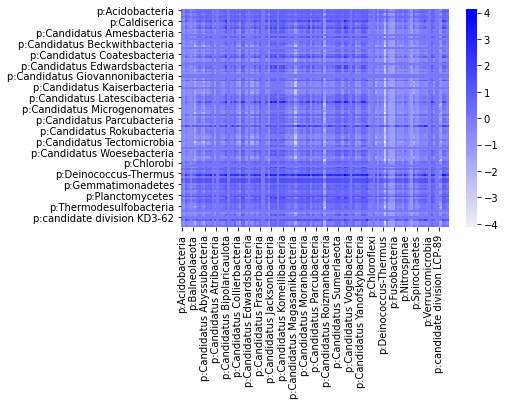

In [25]:
sns.heatmap(cohend, cmap=sns.color_palette("light:b", as_cmap=True))

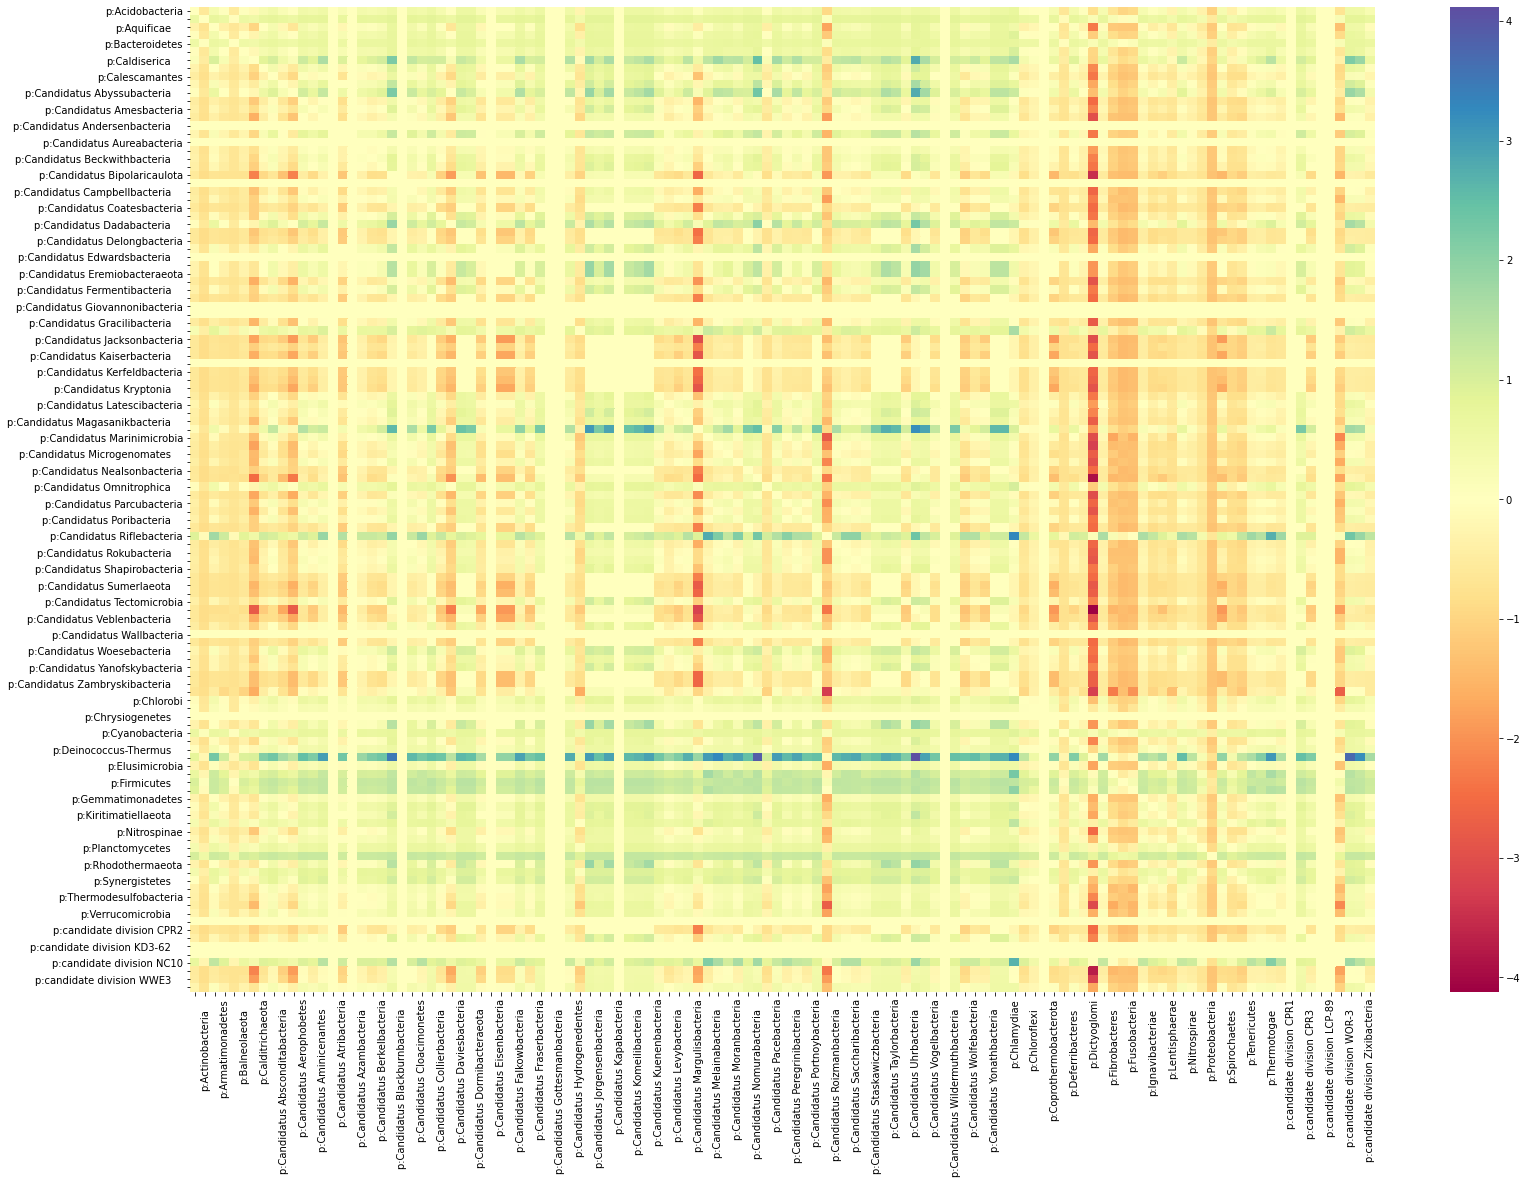

In [35]:
fig, ax = plt.subplots(1,1, figsize=(23.4,16.54))
sns.heatmap(cohend,  cmap=sns.color_palette("Spectral", as_cmap=True), ax=ax, xticklabels=1, yticklabels=1)


# get the tick labels and change some parameters about them.
xticks_loc = ax.get_xticklabels()
lx = ax.set_xticklabels(xticks_loc, fontsize=10)
# use this to hide every other tick
[x.set_visible(False) for x in lx[::2]]

yticks_loc = ax.get_yticklabels()
ly = ax.set_yticklabels(yticks_loc, fontsize=10)
# use this to hide every other tick
[y.set_visible(False) for y in ly[1::2]]


# add a slight offset for every other x tick label
for alab in lx[1::4]:
    x, y = alab.get_position()
    alab.set_position((x, y-0.01))

# add a slight offset for every other y tick label
for alab in ly[2::4]:
    x, y = alab.get_position()
    alab.set_position((x-0.01, y))




plt.tight_layout()
fig.savefig('images/cohen_heatmap.tiff')

In [30]:
a=[1,2,3,4,5,6,7,8,9]
print(a[::2])
print(a[1::2])

[1, 3, 5, 7, 9]
[2, 4, 6, 8]
